In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt
import iris.quickplot as qplt

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cartopy.crs as ccrs  
#import mo_pack
from matplotlib import ticker, cm
#import imageio
import iris.analysis.cartography
from iris.analysis.cartography import _meshgrid, rotate_pole, rotate_winds
from aeolus.coord import get_xy_coords
from iris.coords import AuxCoord
from iris.util import promote_aux_coord_to_dim_coord
import aeolus
from iris.coord_systems import RotatedGeogCS
from aeolus.calc.diag import lat_cos
from iris.util import reverse
from aeolus.calc.stats import cumsum, spatial
from aeolus.coord import roll_cube_pm180, volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels
import matplotlib.colors as colors 
from aeolus.const import init_const
import matplotlib
pcb_const=init_const('proxb')




In [2]:
warnings.filterwarnings("ignore")


# Loading the data

In [3]:
pcb_tl = iris.load('data/pcb_tl_o3circ_8340_900.nc')#data/pcb_nox_7560_120_ste.nc')#pcb_tl_o3circ_8340_900.nc')#/pcb_bnox_7560_120.nc')#
#../proxcencomp/data_b/pcb_bnox_musc_7440_120_2

# Relevant functions for statistics, slicing, regridding

Renaming vertical coordinate for all cubes


In [5]:
def newheight(cubes, max_tslice=-1):            
    for cube in cubes:
        if cube.coords()[1].long_name=='Hybrid height':
            height_new = cube.coord('Hybrid height')
            height_new.rename('level_height')
newheight(pcb_tl)


In [33]:

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume


def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    daymean = meridional_mean(zonal_mean(daycube))
    nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daymean, nightmean

def height_to_pressure(cube, pressurecube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = pressurecube.interpolate(height, iris.analysis.Linear())
    rflux_reg=interp_cube_from_height_to_pressure_levels(cube, p_reg, meridional_mean(zonal_mean(p_reg)).data)
    return rflux_reg 



def vmr_molec(cube, p_cube, t_cube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = p_cube.interpolate(height, iris.analysis.Linear())
    volume = volume_weights_cube2(cube)
    nair=(p_reg*volume)/((1.38*10**(-23))*t_cube) #nair in molec/gridbox
    cube_molec = cube*nair/volume #n_o3 in molec/m3
    cube_molec *= 1e-6
    return cube_molec

    
def regrid_to_rotated_pole_coordinates(cube, pole_lon, pole_lat, model=aeolus.model.um):
    """
    Regrid a cube to rotated-pole coordinates.

    Note: non-dimensional coordinates are lost.

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube.
    pole_lon: float
        New North Pole longitude.
    pole_lat: float
        New North Pole latitude.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate and variable names.
    """
    _cs = cube.coord_system()
    xcoord, ycoord = get_xy_coords(cube, model=model)
    lon2d, lat2d = _meshgrid(xcoord.points, ycoord.points)
    r_lons, r_lats = rotate_pole(lon2d, lat2d, pole_lon, pole_lat)

    r_lon_coord = AuxCoord(
        r_lons.flatten(),
        units=xcoord.units,
        standard_name=xcoord.standard_name,
        var_name=xcoord.var_name,
        coord_system=_cs,
    )
    r_lat_coord = AuxCoord(
        r_lats.flatten(),
        units=ycoord.units,
        standard_name=ycoord.standard_name,
        var_name=ycoord.var_name,
        coord_system=_cs,
    )
    non_xy_coords = [(i, cube.coord_dims(i)) for i in cube.dim_coords if i not in [xcoord, ycoord]]
    # assume latitude and longitude are the rightmost dimensions
    lat_dim = len(non_xy_coords)
    if lat_dim != cube.coord_dims(ycoord)[0]:
        raise BadCoordinateError("Ensure latitude and longitude are the rightmost dimensions.")
    cube_flat = iris.cube.Cube(
        cube.core_data().reshape((*cube.shape[:lat_dim], np.product(cube.shape[lat_dim:]))),
        aux_coords_and_dims=[
            *non_xy_coords,
            (r_lat_coord, lat_dim),
            (r_lon_coord, lat_dim),
        ],
        units=cube.units,
    )
    for coord, _ in non_xy_coords:
        promote_aux_coord_to_dim_coord(cube_flat, coord)

    out = cube_flat.regrid(cube, iris.analysis.UnstructuredNearest())
    return out



def regrid_to_tidally_locked_coordinates(cube, pole_lon=0, pole_lat=0, model=aeolus.model.um):
    """
    Regrid a cube to tidally locked coordinates.

    The substellar and antistellar point become the north and south pole, respectively.
    By default, the substellar point is assumed to be at (0, 0).

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube.
    pole_lon: float, optional
        New North Pole longitude.
    pole_lat: float, optional
        New North Pole latitude.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate and variable names.
    """
    return regrid_to_rotated_pole_coordinates(
        cube, pole_lon=pole_lon, pole_lat=pole_lat, model=model
    )

def rotate_winds_to_tidally_locked_coordinates(u, v, pole_lon=0, pole_lat=0):
    """
    Rotate the horizontal wind components to tidally locked coordinates.

    The substellar and antistellar point become the north and south pole, respectively.
    By default, the substellar point is assumed to be at (0, 0).

    Parameters
    ----------
    u: iris.cube.Cube
        An instance of :class:`iris.cube.Cube` that contains the x-component of the vector.
    v: iris.cube.Cube
        An instance of :class:`iris.cube.Cube` that contains the y-component of the vector.
    pole_lon: float, optional
        New North Pole longitude.
    pole_lat: float, optional
        New North Pole latitude.
    """
    tl_cs = RotatedGeogCS(pole_lon, pole_lat, ellipsoid=u.coord_system())
    tl_u, tl_v = rotate_winds(u, v, tl_cs)
    return tl_u, tl_v

def add_coord_system(cube, radius):
    _coord_system = iris.coord_systems.GeogCS(semi_major_axis=radius, longitude_of_prime_meridian=0)
    for dim, standard_name in zip(["x", "y"], ["longitude", "latitude"]):
        dim_name = getattr(model_names, dim)
        try:
            cube.coord(dim_name).units = "degrees"
            cube.coord(dim_name).rename(standard_name)
            cube.coord(dim_name).coord_system = _coord_system
        except iris.exceptions.CoordinateNotFoundError:
            pass
        

# Transformation to tidally-locked coordinate system for relevant diagnostics

In [7]:
def regrid_cubelist(cubes, max_tslice=1):            
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name == 'northward_wind':
            y_wind = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name == 'surface_temperature':
            tsurf = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name =='air_pressure':
            pressure = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name =='air_temperature':
            temperature = cube[:max_tslice,:,:,:].copy()
        if cube.standard_name =='upward_air_velocity':
            z_wind = cube[:max_tslice,:,:,:].copy()
        if cube.long_name == 'O3 MASS MIXING RATIO':
            o3vmr = cube[:max_tslice].copy()
        if cube.long_name == 'Stash code = 50219':
            toc = cube[:max_tslice].copy()       
        if cube.long_name == 'Stash code = 50501':
            r_23_o3 = cube[:max_tslice].copy()
        if cube.long_name == 'Stash code = 50051':
            ste = cube[:max_tslice].copy()            
        if cube.long_name == 'Stash code = 50054':
            o3tendency = cube[:max_tslice].copy() 
        if cube.long_name == 'HONO2 MASS MIXING RATIO':
            hno3vmr = cube[:max_tslice].copy()
        if cube.long_name == 'N2O5 MASS MIXING RATIO':
            n2o5vmr = cube[:max_tslice].copy()    
    print(x_wind)                    
    x_wind = x_wind.regrid(y_wind, iris.analysis.Linear())
    #Note that we calculate the divergent wind components here to calculate the streamfunction
    vec = windspharm.iris.VectorWind(x_wind,y_wind, rsphere=7160000)
    x_wind_div, y_wind_div = vec.irrotationalcomponent(truncation=None)
    #print(y_wind.coord('longitude').coord_system)
    y_wind.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)    
    y_wind.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    y_wind_div.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)    
    y_wind_div.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    
    x_wind.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind_div.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind_div.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    
    pressure.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0) 
    pressure.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    temperature.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    temperature.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    z_wind.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    z_wind.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    o3vmr.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    o3vmr.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    toc.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    toc.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    r_23_o3.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    r_23_o3.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    ste.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    ste.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    o3tendency.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)  
    o3tendency.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    #hno3vmr.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    #hno3vmr.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    #n2o5vmr.coord('latitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    #n2o5vmr.coord('longitude').coord_system = iris.coord_systems.GeogCS(semi_major_axis= pcb_const.radius.data, longitude_of_prime_meridian=0)
    x_wind, y_wind = rotate_winds_to_tidally_locked_coordinates(x_wind, y_wind, pole_lon=0, pole_lat=0)
    x_wind_div, y_wind_div = rotate_winds_to_tidally_locked_coordinates(x_wind_div, y_wind_div)
    #print(y_wind.coord('longitude').coord_system)#('projection_x_coordinate').points)
    y_wind=regrid_to_tidally_locked_coordinates(y_wind)
    x_wind=regrid_to_tidally_locked_coordinates(x_wind)
    y_wind_div=regrid_to_tidally_locked_coordinates(y_wind_div)
    x_wind_div=regrid_to_tidally_locked_coordinates(x_wind_div)    
    tsurf=regrid_to_tidally_locked_coordinates(tsurf)
    pressure=regrid_to_tidally_locked_coordinates(pressure)
    temperature=regrid_to_tidally_locked_coordinates(temperature)
    z_wind=regrid_to_tidally_locked_coordinates(z_wind)
    o3vmr=regrid_to_tidally_locked_coordinates(o3vmr)*29.3/48
    toc=regrid_to_tidally_locked_coordinates(toc)
    r_23_o3=regrid_to_tidally_locked_coordinates(r_23_o3)
    ste=regrid_to_tidally_locked_coordinates(ste)
    o3tendency=regrid_to_tidally_locked_coordinates(o3tendency)
    #hno3vmr=regrid_to_tidally_locked_coordinates(hno3vmr)*29.3/63.01
    #n2o5vmr=regrid_to_tidally_locked_coordinates(n2o5vmr)*29.3/108.01
    new_cubes = iris.cube.CubeList([pressure, temperature, tsurf, x_wind, y_wind, z_wind, o3vmr, toc, r_23_o3,
                                    ste, o3tendency, x_wind_div, y_wind_div])#, n2o5vmr, hno3vmr])
    new_cubes[0].standard_name = 'air_pressure'
    new_cubes[1].standard_name = 'air_temperature'
    new_cubes[2].standard_name = 'surface_temperature'
    new_cubes[3].standard_name = 'eastward_wind'
    new_cubes[4].standard_name = 'northward_wind'
    new_cubes[5].standard_name = 'upward_air_velocity'
    new_cubes[6].long_name = 'O3 MASS MIXING RATIO'
    new_cubes[7].long_name = 'Stash code = 50219'
    new_cubes[8].long_name = 'Stash code = 50501'
    new_cubes[9].long_name = 'Stash code = 50051'
    new_cubes[10].long_name = 'Stash code = 50054'
    new_cubes[11].long_name = 'eastward_wind_div'
    new_cubes[12].long_name = 'northward_wind_div'
    #new_cubes[13].long_name = 'N2O5 MASS MIXING RATIO'
    #new_cubes[14].long_name = 'HNO3 MASS MIXING RATIO'
    return new_cubes

pcb_tl_regrid=regrid_cubelist(pcb_tl, max_tslice=100)


eastward_wind / (m s-1)             (t: 100; level_height: 60; latitude: 90; longitude: 144)
    Dimension coordinates:
        t                             x                  -             -              -
        level_height                  -                  x             -              -
        latitude                      -                  -             x              -
        longitude                     -                  -             -              x
    Attributes:
        date                        '25/09/24'
        history                     'Thu Mar  2 14:53:52 UTC 2023 - XCONV V1.92 16-February-2006'
        name                        'u'
        source                      'Unified Model Output (Vn12.0):'
        time                        '00:00'
        title                       'U COMPNT OF WIND AFTER TIMESTEP'
        valid_max                   164.93321
        valid_min                   -216.42386


# Figures 2a and b: Temperature distribution in two coordinate systems

Minimum temp: [156.83376]
Max temp: [289.02585]
28750.57
[8000.002]


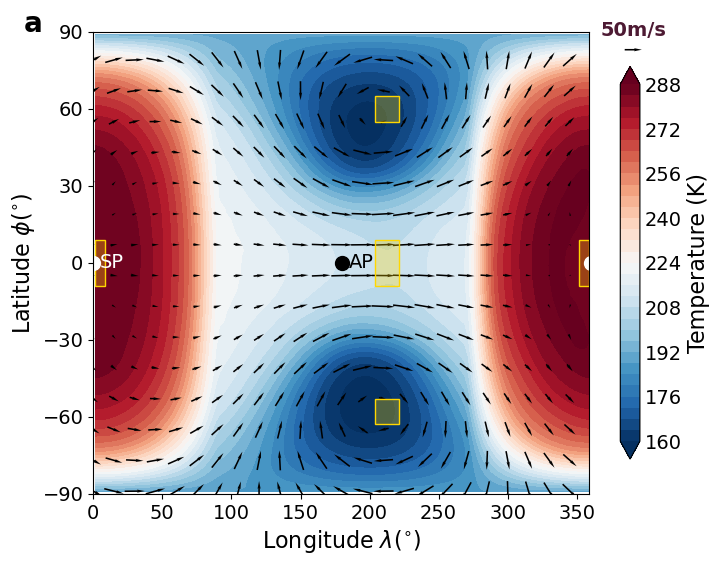

Minimum temp: [156.8535]
Max temp: [289.02585]
29605.91
[8000.002]


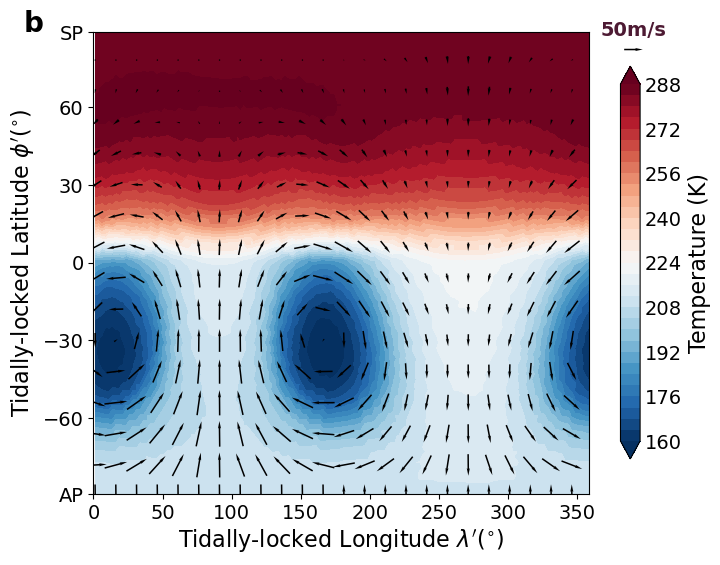

In [8]:


def plot_tsurf(cubes, time_slice=-1, vert_slice=-1, time_mean=False, tl_coord=False, markers=False, sublabel=False,
               sublabel_t='a',save=False, name=None):            
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                x_wind = cube[:100,:,:,:].copy()
                x_wind=x_wind.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'northward_wind':
            y_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                y_wind = cube[:100,:,:,:].copy()
                y_wind=y_wind.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='surface_temperature':
            temperature = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                temperature = cube[:100,:,:,:].copy()
                temperature=temperature.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_pressure':
            pressure = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                pressure = cube[:100,:,:,:].copy()
                pressure=pressure.collapsed('t', iris.analysis.MEAN)
    
    y_wind = y_wind.regrid(x_wind, iris.analysis.Linear())
    #vec = windspharm.iris.VectorWind(x_wind,y_wind, rsphere=7160000)
    #x_wind, y_wind = vec.irrotationalcomponent(truncation=None)
    xlon = x_wind.coord('longitude')
    ylon = y_wind.coord('longitude')
    print('Minimum temp:', spatial(temperature, 'min').data)
    print('Max temp:', spatial(temperature, 'max').data)
    # Create a cube containing the wind speed
    windspeed = (y_wind** 2 + x_wind ** 2) ** 0.5
    windspeed.rename('windspeed')

    xe = xlon.points#-180
    ye = y_wind.coord('latitude').points
    ue = x_wind[vert_slice, :, :].data
    ve = y_wind[vert_slice, :, :].data
    #print(temperature[25,:,:].coord(''))
    print(pressure[vert_slice,0,0].data)
    print(pressure[vert_slice,0,0].coord('level_height').points)
    levs273=np.arange(273.14,273.16,1)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.14,1.0, sublabel_t, size=20, weight='bold',transform=ax.transAxes)
    c=plt.contourf(temperature[0,:,:].coord('longitude').points,temperature[0,:,:].coord('latitude').points,
                   temperature[0,:,:].data, levels=25, extend='both',cmap='RdBu_r')
    c=plt.contourf(temperature[0,:,:].coord('longitude').points,temperature[0,:,:].coord('latitude').points,
                   temperature[0,:,:].data, levels=40, extend='both',cmap='RdBu_r')
    #c2 = plt.contour(temperature[0,:,:].coord('longitude').points, temperature[0,:,:].coord('latitude').points,
    #                 temperature[0,:,:].data, levs273,linewidths=2.0, colors='white', linestyles='-')
    cbar = fig.colorbar(c, shrink=0.85)
    cbar.ax.set_ylabel('Temperature (K)', rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=14) 
    qv1=ax.quiver(xe[::6], ye[::6], ue[::6, ::6], ve[::6, ::6], pivot='middle', headwidth=2)
    ax.quiverkey(qv1, 0.8, 0.85, 50, r'50m/s', labelcolor=(0.3, 0.1, .2, 1),
                   labelpos='N', coordinates = 'figure', fontproperties={'size': 14, 'weight': 'bold'})
    #plt.title('T$_{surf}$, winds at %s Pa' %(np.round(pressure[vert_slice,0,0].data,1)), fontsize=16)
    if tl_coord==True:
        ax.yaxis.set_major_locator(plt.MaxNLocator(7))
        plt.ylabel('Tidally-locked Latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        plt.xlabel('Tidally-locked Longitude $\lambda^{\prime} (^{\circ})$', fontsize=16)
        #         plt.axvline(70, color='grey')#65
#         plt.axvline(110, color='grey')#115
#         plt.axvline(230, color='grey')#220
#         plt.axvline(305, color='grey')#312
        #plt.title('T$_{surf}$, tidally-locked coordinates', fontsize=16)
        plt.draw() # this is required, or the ticklabels may not exist (yet) at the next step
        labels = [w.get_text() for w in ax.get_yticklabels()]
        locs=list(ax.get_yticks())
        labels+=['SP']
        locs+=[89]
        labels+=['AP']
        locs+=[-89]        
        ax.set_yticklabels(labels)
        ax.set_yticks(locs)
        #ax.grid()
        plt.draw()
        plt.ylim(-89,89)

    else:
        ax.yaxis.set_major_locator(plt.MaxNLocator(7))
        plt.ylabel('Latitude $\phi (^{\circ})$', fontsize=16)
        plt.xlabel('Longitude $\lambda (^{\circ})$', fontsize=16)
        #plt.title('T$_{surf}$, geographic coordinates', fontsize=16)
    
        plt.ylim(-90,90)
        if markers==True:
            pp1 = plt.Rectangle((temperature[0,:,0].coord('longitude').points, temperature[0,40,:].coord('latitude').points),
                                temperature[0,:,3].coord('longitude').points-temperature[0,:,0].coord('longitude').points
                                , temperature[0,49,:].coord('latitude').points-temperature[0,40,:].coord('latitude').points, 
                               edgecolor=(255/255,215/255,0/255, 1), facecolor=(255/255,215/255,0/255, 0.3))
            pp2 = plt.Rectangle((temperature[0,:,140].coord('longitude').points, temperature[0,40,:].coord('latitude').points),
                                temperature[0,:,143].coord('longitude').points-temperature[0,:,140].coord('longitude').points
                                , temperature[0,49,:].coord('latitude').points-temperature[0,40,:].coord('latitude').points, 
                               edgecolor=(255/255,215/255,0/255, 1), facecolor=(255/255,215/255,0/255, 0.3))       
            ppj = plt.Rectangle((temperature[0,:,81].coord('longitude').points, temperature[0,40,:].coord('latitude').points),
                                temperature[0,:,88].coord('longitude').points-temperature[0,:,81].coord('longitude').points
                                , temperature[0,49,:].coord('latitude').points-temperature[0,40,:].coord('latitude').points, 
                               edgecolor=(255/255,215/255,0/255, 1), facecolor=(255/255,215/255,0/255, 0.3))   
            ppng = plt.Rectangle((temperature[0,:,81].coord('longitude').points, temperature[0,72,:].coord('latitude').points),
                                temperature[0,:,88].coord('longitude').points-temperature[0,:,81].coord('longitude').points
                                , temperature[0,77,:].coord('latitude').points-temperature[0,72,:].coord('latitude').points, 
                               edgecolor=(255/255,215/255,0/255, 1), facecolor=(255/255,215/255,0/255, 0.3))   
            ppsg = plt.Rectangle((temperature[0,:,81].coord('longitude').points, temperature[0,13,:].coord('latitude').points),
                                temperature[0,:,88].coord('longitude').points-temperature[0,:,81].coord('longitude').points
                                , temperature[0,18,:].coord('latitude').points-temperature[0,13,:].coord('latitude').points, 
                               edgecolor=(255/255,215/255,0/255, 1), facecolor=(255/255,215/255,0/255, 0.3))
            ax.add_patch(pp1)
            ax.add_patch(pp2)
            ax.add_patch(ppj)
            ax.add_patch(ppng)
            ax.add_patch(ppsg)

        plt.text(5,0,'SP',horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
        plt.scatter(0,0, s=100, color='white')
        plt.scatter(360,0, s=100, color='white')
        plt.text(185,0,'AP',horizontalalignment='left', verticalalignment='center', fontsize=14, color='black')
        plt.scatter(180,0, s=100, color='black')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,359)
    if save==True:
        plt.savefig('%s.pdf' %(name), bbox_inches = 'tight')
    plt.show()

plot_tsurf(pcb_tl, time_slice=0, vert_slice=20, time_mean=True, markers=True, save=True, name='pcb_tsurf', 
           sublabel=True, sublabel_t='a')
plot_tsurf(pcb_tl_regrid, time_slice=0, vert_slice=20, time_mean=True, tl_coord=True,save=True, name='pcb_tl_tsurf', 
           sublabel=True, sublabel_t='b')

# Figures 3a: Ozone distribution in tidally-locked coordinates

Minimum temp: 265.7428
Max temp: 1415.5415
N high latitudes day mean: 283.0142440837316
high lambda gyre mean: 601.4721217897651
Tropical latitudes day mean: 341.3134827707074
S high latitudes day mean: 303.75111112363857
Low lambda gyre mean: 680.3955594400545


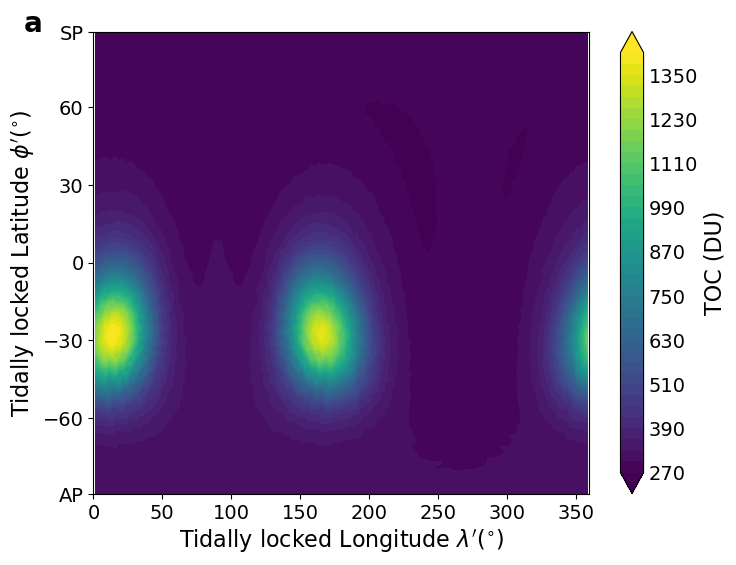

In [10]:
def plot_toc(cubes, time_slice=-1, time_mean=False, tl_coord=False, sublabel=False,
               sublabel_t='a'):            
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                x_wind = cube[:,:,:,:].copy()
                x_wind=x_wind.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'northward_wind':
            y_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                y_wind = cube[:,:,:,:].copy()
                y_wind=y_wind.collapsed('t', iris.analysis.MEAN)            
        if cube.long_name =='Stash code = 50219':
            temperature = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                temperature = cube[:,:,:,:].copy()
                temperature=temperature.collapsed('t', iris.analysis.MEAN)    
#     rotywind = y_wind.regrid(x_wind, iris.analysis.Linear())
#     xlon = x_wind.coord('longitude')
#     ylon = y_wind.coord('longitude')

#     # Create a cube containing the wind speed
#     windspeed = (rotywind** 2 + x_wind ** 2) ** 0.5
#     windspeed.rename('windspeed')

#     xe = xlon.points#-180
#     ye = rotywind.coord('latitude').points
#     ue = x_wind[19, :, :].data
#     ve = rotywind[19, :, :].data
    print('Minimum temp:', spatial(temperature[0], 'min').data)
    print('Max temp:', spatial(temperature[0], 'max').data)   
    print('N high latitudes day mean:', spatial(temperature.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: 80 <= v <= 90))[0], 'mean').data)
    print('high lambda gyre mean:', spatial(temperature.extract(iris.Constraint(longitude=lambda v: 110 <= v <= 220,
                                    latitude=lambda v: -60 <= v <= 0))[0], 'mean').data)
    print('Tropical latitudes day mean:', spatial(temperature.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -10 <= v <= 10))[0], 'mean').data)
    print('S high latitudes day mean:', spatial(temperature.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= -80))[0], 'mean').data)
    print('Low lambda gyre mean:', spatial(temperature.extract(iris.Constraint(longitude=lambda v: v <= 70,
                                    latitude=lambda v: -60 <= v <= 0))[0], 'mean').data)
    
    lev_expcol = np.arange(2.4,3.2,0.01)
    levscol = np.power(10, lev_expcol)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.14,1.0, sublabel_t, size=20, weight='bold',transform=ax.transAxes)
    c=plt.contourf(temperature[0,:,:].coord('longitude').points,temperature[0,:,:].coord('latitude').points,
                   temperature[0,:,:].data, levels=25, extend='both', cmap='viridis')#, locator=ticker.LogLocator())
    c=plt.contourf(temperature[0,:,:].coord('longitude').points,temperature[0,:,:].coord('latitude').points,
                   temperature[0,:,:].data, levels=40, extend='both', cmap='viridis')#, locator=ticker.LogLocator())
    cbar = fig.colorbar(c)
    cbar.ax.set_ylabel('TOC (DU)', rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=14) 
    if tl_coord==True:
        ax.yaxis.set_major_locator(plt.MaxNLocator(7))
        plt.ylabel('Tidally locked Latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        plt.xlabel('Tidally locked Longitude $\lambda^{\prime} (^{\circ})$', fontsize=16)
#         plt.axvline(70, color='darkorange')#65
#         plt.axvline(110, color='darkorange')#115
#         plt.axvline(220, color='darkorange')#220
#         plt.axvline(315, color='darkorange')#312
        plt.draw() # this is required, or the ticklabels may not exist (yet) at the next step
        labels = [w.get_text() for w in ax.get_yticklabels()]
        locs=list(ax.get_yticks())
        labels+=['SP']
        locs+=[89]
        labels+=['AP']
        locs+=[-89]        
        ax.set_yticklabels(labels)
        ax.set_yticks(locs)
        #ax.grid()
        plt.draw()
        plt.ylim(-89,89)
    else:
        ax.yaxis.set_major_locator(plt.MaxNLocator(7))
        plt.ylabel('Latitude $\phi (^{\circ})$', fontsize=16)
        plt.xlabel('Longitude $\lambda (^{\circ})$', fontsize=16)
        plt.ylim(-90,90)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,360)
#     plt.axvline(202, color='darkorange')
#     plt.axvline(218, color='darkorange')
#     plt.axhline(-62, color='darkorange')
#     plt.axhline(-54, color='darkorange')
#     plt.axhline(-10, color='darkorange')
#     plt.axhline(10, color='darkorange')
#     plt.axhline(62, color='darkorange')
#     plt.axhline(55, color='darkorange')
    if tl_coord==True:
        plt.savefig('pcb_toc_tl.pdf', bbox_inches = 'tight')
    plt.show()
#plot_toc(pcb_tl, time_slice=0, time_mean=True)
plot_toc(pcb_tl_regrid, time_slice=0, time_mean=True, tl_coord=True, sublabel=True, sublabel_t='a')


# Figure 2b: Vertical distribution of ozone number density

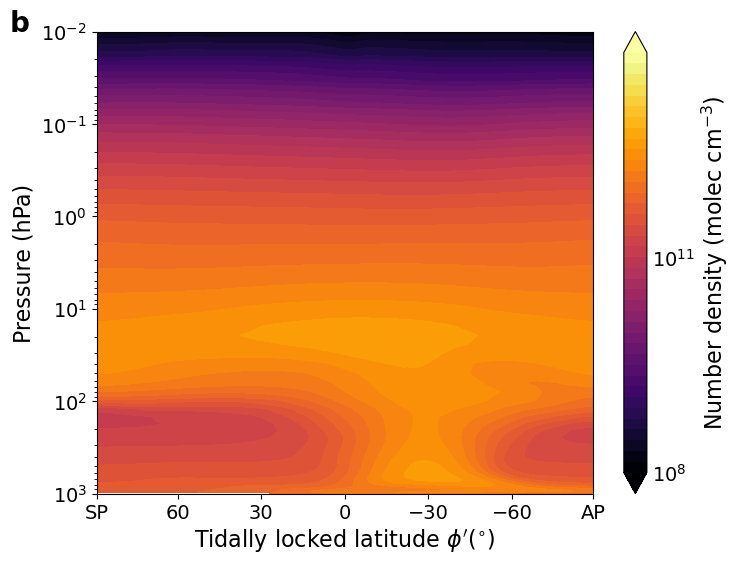

In [21]:
def meridional_mass_streamfunction_moldistrib(cubelist, lname_mol='O3 MASS MIXING RATIO', m_mol=48, time_slice_l=0,
                                              time_slice_u=120,vmin=None, vmax=None, sublabel=False, sublabel_t='a',
                                   tl_coords=False, max_o3=2e3, const=None, model=aeolus.model.um):
    for cube in cubelist:
        if cube.long_name == 'eastward_wind_div':
            u = cube[time_slice_l:time_slice_u,:,:,:].copy()
            u=u.collapsed('t', iris.analysis.MEAN)
        if cube.long_name == 'northward_wind_div':
            v = cube[time_slice_l:time_slice_u,:,:,:].copy()
            v=v.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_pressure':
            pres_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_temperature':
            temp_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
        if cube.long_name == lname_mol:
            vmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            vmr = vmr.collapsed('t', iris.analysis.MEAN)*29.3/m_mol
    v = v.regrid(u, iris.analysis.Linear())
    height = [('level_height', v.coord('level_height').points)]
    pres_cube = pres_cube.interpolate(height, iris.analysis.Linear())
    #print(pres_cube)
    temp_cube = temp_cube.interpolate(height, iris.analysis.Linear())
    vmr = vmr.interpolate(height, iris.analysis.Linear())    
    #print(vmr)
    rho =pres_cube / (const.molar_gas_constant * temp_cube)
    
    vmr = vmr_molec(vmr, pres_cube, temp_cube)
    vmr_p = height_to_pressure(vmr, pres_cube)
    vmr_p_day, __ = hemisphere_sep(vmr_p)
    vmr_zonal_p = zonal_mean(vmr_p)
    vmr_meridional_p = meridional_mean(vmr_p)
    vmr_zonal = zonal_mean(vmr)
    vmr_meridional = meridional_mean(vmr)
    
    lats = [('latitude', rho.coord('latitude').points)]
    v = v.interpolate(lats, iris.analysis.Linear())
        
    v = zonal_mean(v)
    rho = zonal_mean(rho)
    rho.coord('level_height').bounds = None
    v.coord('level_height').bounds = None
        # Reverse the coordinate to start from the model top (where p=0 or z=z_top)
        # TODO: check if the coordinate is ascending or descending
    integrand = reverse(v * rho, 'level_height')
    res = -1 * cumsum(integrand, "z", axis_weights=True, model=model)
        # Reverse the result back
    res = reverse(res, model.z)

    # Calculate the constant: 2 pi cos\phi a
    streamf_const = 2 * np.pi * const.radius * lat_cos(res, model=model)
    res *= streamf_const
    
    pressure_zm = zonal_mean(pres_cube)
    res_p=interp_cube_from_height_to_pressure_levels(res, pressure_zm[:,:], pressure_zm[:,0].data)
    #levs=np.arange(-1.3e25, 1.43e25, 0.13e25)
    #lev_expcol = np.arange(-13,13,0.65)
    
    #print(vmr_zonal_p)
    lev_exp_vmr = np.arange(8,14,0.15)
    levs_vmr = np.power(10, lev_exp_vmr)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.175,1.0, sublabel_t, size=20, weight='bold',transform=ax.transAxes)
    if tl_coords==True:
        ax.xaxis.set_major_locator(plt.MaxNLocator(7))
        levs=[-1e14,-1e13,-1e12,-1e11,-1e10,-1e9,-1e8,1e8,1e9,1e10,1e11,1e12,1e13,1e14]
        cs = plt.contourf(vmr_zonal_p[:,:].coord('latitude').points, vmr_zonal_p[:,:].coord('air_pressure').points/100, 
                           vmr_zonal_p[:,:].data, levels=40, extend='both', 
                           cmap='inferno', locator=ticker.LogLocator())
        cs = plt.contourf(vmr_zonal_p[:,:].coord('latitude').points, vmr_zonal_p[:,:].coord('air_pressure').points/100, 
                           vmr_zonal_p[:,:].data, levels=levs_vmr, extend='both', 
                           cmap='inferno', locator=ticker.LogLocator())

        #cs2 = iplt.contour(-1*res_p[:,:], levels=levs, colors='black', norm=colors.SymLogNorm(
        #               linthresh=1e8, vmin=-1e14, vmax=1e14))
        #plt.scatter(87, max_o3, c='grey', s=600, marker='P')
#        cs = iplt.contourf(-1*res_p[:,:], levels=levs, cmap='coolwarm', norm=colors.SymLogNorm(
#        linthresh=1e8, vmin=-1e13, vmax=1e13))
##        cs = iplt.contourf(-1*res_p[:,:], levels=35, cmap='PuOr_r', extend='both', locator=ticker.LogLocator(), norm=colors.TwoSlopeNorm(vmin=vmin,
##                                                                                                            vcenter=0, vmax=vmax))
        plt.xlabel('Tidally locked latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        plt.gca().invert_xaxis()
        plt.draw() # this is required, or the ticklabels may not exist (yet) at the next step
        labels = [w.get_text() for w in ax.get_xticklabels()]
        locs=list(ax.get_xticks())
        labels+=['SP']
        locs+=[89]
        labels+=['AP']
        locs+=[-89]        
        ax.set_xticklabels(labels)
        ax.set_xticks(locs)
        #ax.grid()
        plt.draw()
        plt.xlim(89,-89)
    else:
        levs=[-1e13,-1e12,-1e11,-1e10,-1e9,-1e8,1e8,1e9,1e10,1e11,1e12,1e13]
        cs = plt.contourf(vmr_zonal_p[:,:], levels=levs_vmr, extend='both', 
                           cmap='inferno', locator=ticker.LogLocator())

        #cs2 = plt.contour(res_p.coord('latitude').points, res_p.coord('air_pressure').points,
        #               res_p.data, levels=levs, colors='black',norm=colors.SymLogNorm(
        #               linthresh=1e8, vmin=-1e13, vmax=1e13))
        #plt.scatter(0, max_o3, c='grey', s=600, marker='P')
        #cs = iplt.contourf(res_p[:,:], levels=levs, cmap='coolwarm',norm=colors.SymLogNorm(
        #linthresh=100000000, vmin=-10000000000000, vmax=10000000000000))
        plt.xlabel('Latitude $\phi (^{\circ})$', fontsize=16)
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel('Number density (molec cm$^{-3}$)', rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=14)
    #plt.title('t=%s days' %(time_slice_u), fontsize=14)
    #plt.gca().set_title(r'Latitude $1^\circ\mathrm{N}$', fontsize=20)
    plt.ylabel('Pressure (hPa)', fontsize=16)
    plt.yscale('log')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.ylim(1e3,1e-2)#96500
    plt.savefig('pcb_no3_tl_merid.pdf', bbox_inches = 'tight')
    plt.show()
#meridional_mass_streamfunction_moldistrib(pcb_tl, const=pcb_const, tl_coords=False)
meridional_mass_streamfunction_moldistrib(pcb_tl_regrid, const=pcb_const, tl_coords=True, sublabel=True, sublabel_t='b')

# Figure 4: vertical distribution of ozone tendency (chemical production-loss)

In [22]:
n_a=6.0221409e23
def integrate(cube, coord):
    """
    Integrate the cube along a 1D coordinate using the trapezoidal rule.

    Note: `coord` must be one of the dimensional coordinates of the cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube containing the given coordinate.
    coord: str or iris.coords.Coord
        Coordinate for integration.

    Returns
    -------
    iris.cube.Cube
        Integrated cube.
    """
    # TODO: allow non-dim coordinates
    c = cube.coord(coord)
    others = [dc.name() for dc in cube.dim_coords if cube.coord_dims(dc) != cube.coord_dims(c)]
    dim = cube.coord_dims(c)[0]
    data = np.trapz(cube.data, c.points, axis=dim)
    res = next(cube.slices(others)).copy(data=data)
    res.units = cube.units * c.units
    res.remove_coord(c)
    res.rename(f"integral_of_{cube.name()}_wrt_{c.name()}")
    # ensure_bounds(cube, [c])
    # delta = iris.coords.AuxCoord(c.bounds[:, 1] - c.bounds[:, 0], units=c.units)
    # res = multiply(cube, delta, dim=dim).collapsed(c, iris.analysis.SUM)
    return res

def tendency(cubes, lname='Stash code = 50051', time_slice=0, cbarlab='molecules m$^{-3}$ s$^{-1}$', 
             tl_coord=False, level=0, save=False, name1=None, name2=None, name3=None):
    for cube in cubes:
        if cube.long_name == lname:
            tendency = cube.copy()
            tendency = tendency.collapsed('t', iris.analysis.MEAN)

        if cube.standard_name =='air_pressure':
            pressure = cube.copy() 
            pressure = pressure.collapsed('t', iris.analysis.MEAN)

    volume_tl = volume_weights_cube2(tendency)
    tendency = (tendency*n_a)/volume_tl  
    tendency_vcol=integrate(tendency, 'level_height')
    #print(tendency_vcol)
    height = [('level_height', tendency.coord('level_height').points)]
    pressure = pressure.interpolate(height, iris.analysis.Linear())
    # Regrid so that all three cubes are on the same x, y, z grid. Uses the x_wind as reference for the others
    
    
    p_heights = np.round(pressure.data*1e-05,2)
    km_heights = np.round(pressure.coord('level_height').points*1e-03,1)    
    tendency_p=height_to_pressure(tendency, pressure) 
    tendency_zonal_p = zonal_mean(tendency_p)
    tendency_meridional_p = meridional_mean(tendency_p)
    tendency_zonal = zonal_mean(tendency)
    tendency_meridional = meridional_mean(tendency)

    levs = np.arange(-8e13,8e13,0.1e12)
    #levs = np.power(10, lev_exp)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(tendency_zonal_p[:,:].coord('latitude').points, tendency_zonal_p[:,:].coord('air_pressure').points/100,
                      tendency_zonal_p[:,:].data, levels=levs, extend='both', cmap='seismic')
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel(cbarlab, rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=14)
    #plt.title('t=%s days' %(time_slice), fontsize=14)
    #plt.gca().set_title(r'Latitude $1^\circ\mathrm{N}$', fontsize=20)
    if tl_coord==True:
        plt.gca().invert_xaxis()
        plt.xlabel('Tidally locked Latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        ax.xaxis.set_major_locator(plt.MaxNLocator(7))
        labels = [w.get_text() for w in ax.get_xticklabels()]
        locs=list(ax.get_xticks())
        labels+=['SP']
        locs+=[89]
        labels+=['AP']
        locs+=[-89]        
        ax.set_xticklabels(labels)
        ax.set_xticks(locs)
        #ax.grid()
        plt.draw()
        plt.xlim(89,-89)
    else:
        plt.xlabel('Latitude $\phi (^{\circ})$', fontsize=16)
    plt.ylabel('Pressure(hPa)', fontsize=16)
    plt.yscale('log')
    #plt.scatter(0, max_o3, c='grey', s=600, marker='P')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.ylim(1e3,1e-2)
    if save==True:
        plt.savefig('%s.pdf' %(name1), bbox_inches = 'tight')
    plt.show()
    levs = np.arange(-1e12,1e12,0.25e11)    
    fig = plt.figure(figsize=(8,8))
    cs = plt.contourf(tendency_meridional_p[:,:].coord('longitude').points, tendency_meridional_p[:,:].coord('air_pressure').points/100,
                       tendency_meridional_p[:,:].data, levels=40, extend='both', cmap='seismic')
    cs = plt.contourf(tendency_meridional_p[:,:].coord('longitude').points, tendency_meridional_p[:,:].coord('air_pressure').points/100,
                       tendency_meridional_p[:,:].data, levels=levs, extend='both', cmap='seismic')
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel(cbarlab, rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=14)
    #plt.title('t=%s days' %(time_slice), fontsize=14)
    #plt.gca().set_title(r'Latitude $1^\circ\mathrm{N}$', fontsize=20)
    if tl_coord==True:
        plt.xlabel('Tidally locked Longitude $\lambda^{\prime} (^{\circ})$', fontsize=16)

    else:
        plt.xlabel('Longitude $\lambda (^{\circ})$', fontsize=16)
    plt.ylabel('Pressure(hPa)', fontsize=16)
    plt.yscale('log')
    #plt.scatter(0, max_o3, c='grey', s=600, marker='P')
    #plt.scatter(360, max_o3, c='grey', s=600, marker='P')
    
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.xlim(0,360)
    plt.ylim(1e3,1e-2)
    if save==True:
        plt.savefig('%s.pdf' %(name2), bbox_inches = 'tight')
    plt.show()
    levs_col=np.arange(-1.6e16, 1.6e16,0.8e15)###STE
    #lev_exp = np.arange(12, 14, ((18-12)/40))##HOx1 , locator=ticker.LogLocator()
    #levs = np.power(10, lev_exp)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    c=plt.contourf(tendency_vcol[:,:].coord('longitude').points,tendency_vcol[:,:].coord('latitude').points,
                   tendency_vcol[:,:].data, levels=levs_col, extend='both', cmap='seismic')
    cbar = fig.colorbar(c)
    cbar.ax.set_ylabel('STE column (molecules m$^{-2}$ s$^{-1}$)', rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=16) 
    if tl_coord==True:
        plt.ylabel('Tidally locked Latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        plt.xlabel('Tidally locked Longitude $\lambda^{\prime} (^{\circ})$', fontsize=16)

    else:
        plt.ylabel('Latitude $\phi (^{\circ})$', fontsize=16)
        plt.xlabel('Longitude $\lambda (^{\circ})$', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,359)
    plt.ylim(-89,88)
    if save==True:
        plt.savefig('%s.pdf' %(name3), bbox_inches = 'tight')
    plt.show()

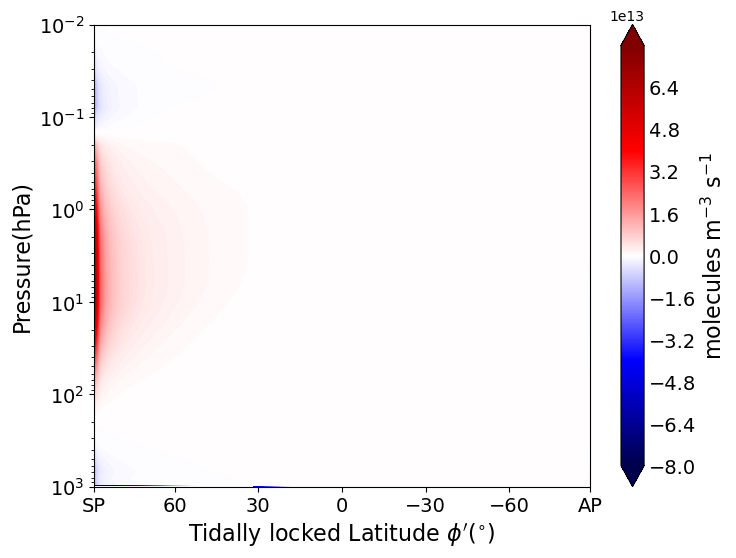

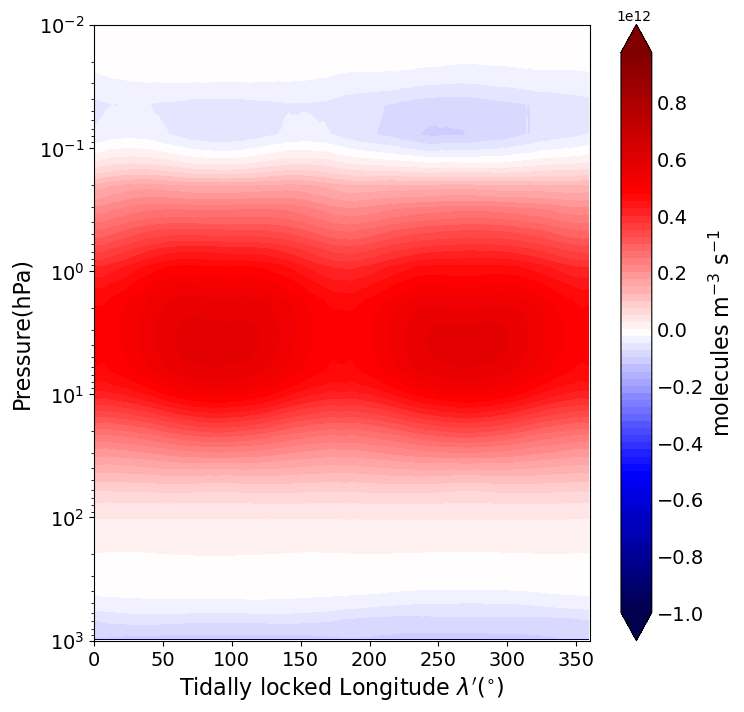

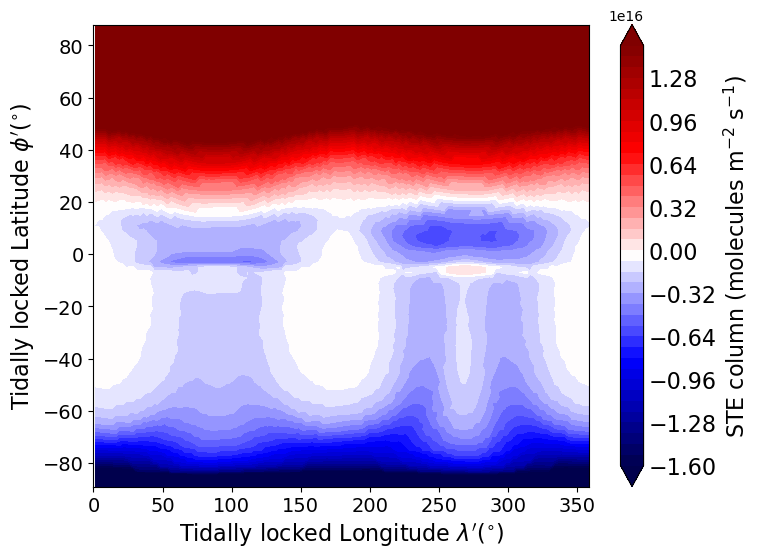

In [23]:
tendency(pcb_tl_regrid, lname='Stash code = 50054', tl_coord=True, save=True, name1='o3tend_tl_merid',
        name2='o3tend_tl_zonal', name3='o3tend_column')


# Figure 5a and b: mean meridional and mean tidally-locked meridional streamfunctions

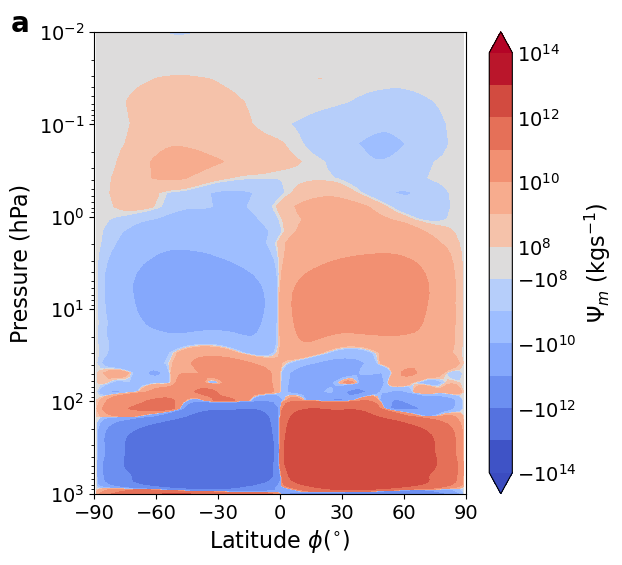

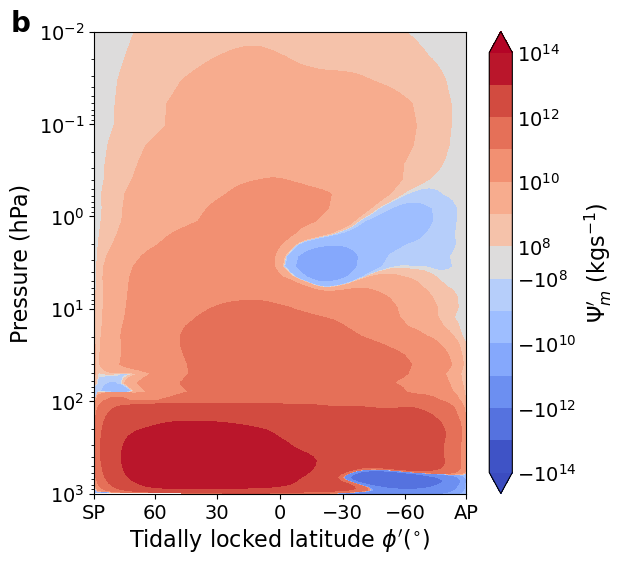

In [24]:
def meridional_mass_streamfunction(cubelist, time_slice=0, vmin=None, vmax=None,day_cube=False,night_cube=False,
                                 lat_min=-90, lat_max=90, lon_min=90,lon_max=270, tl_coords=False, const=None,
                                   save=False, sublabel=False, sublabel_t='a', name=None, model=aeolus.model.um):
    r"""
    Calculate the mean meridional mass streamfunction.

    * In height coordinates

    .. math::
        \Psi_M = - 2\pi cos\phi a \int_{z_{sfc}}^{z_{top}}\overline{\rho v} dz

    * In pressure coordinates

    .. math::
        \Psi_M = 2\pi cos\phi a \int_{0}^{p_{sfc}}\overline{\rho v} dp / g

    """
    for cube in cubelist:

        if cube.standard_name == 'eastward_wind':
            u = cube[:,:,:,:].copy()
            u=u.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max))
        if cube.long_name == 'eastward_wind_div':   #If regridded to tidally-locked coordinates
            u = cube[:,:,:,:].copy()
            u=u.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 

        if cube.standard_name == 'northward_wind':
            v = cube[:,:,:,:].copy()
            v=v.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            v = v.regrid(u, iris.analysis.Linear())
            vec = windspharm.iris.VectorWind(u,v, rsphere=7160000)  
            u, v = vec.irrotationalcomponent(truncation=None)
        if cube.long_name == 'northward_wind_div':   #If regridded to tidally-locked coordinates
            v = cube[:,:,:,:].copy()
            v=v.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.standard_name =='air_pressure':
            pres_cube = cube[:,:,:,:].copy()
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                pres_cube=pres_cube.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                pres_cube=pres_cube.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.standard_name =='air_temperature':
            temp_cube = cube[:,:,:,:].copy()
            temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                temp_cube=temp_cube.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                temp_cube=temp_cube.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
    
    
    height = [('level_height', v.coord('level_height').points)]
    pres_cube = pres_cube.interpolate(height, iris.analysis.Linear())
    temp_cube = temp_cube.interpolate(height, iris.analysis.Linear())
    rho =pres_cube / (const.molar_gas_constant * temp_cube)
    #print(pres_cube[19].data)
    lats = [('latitude', rho.coord('latitude').points)]
    v = v.interpolate(lats, iris.analysis.Linear())
        
    v = zonal_mean(v)
    rho = zonal_mean(rho)
    rho.coord('level_height').bounds = None
    v.coord('level_height').bounds = None
        # Reverse the coordinate to start from the model top (where p=0 or z=z_top)
        # TODO: check if the coordinate is ascending or descending
    integrand = reverse(v * rho, 'level_height')
    res = -1 * cumsum(integrand, "z", axis_weights=True, model=model)
        # Reverse the result back
    res = reverse(res, model.z)

    # Calculate the constant: 2 pi cos\phi a
    streamf_const = 2 * np.pi * const.radius * lat_cos(res, model=model)
    res *= streamf_const
    
    pressure_zm = zonal_mean(pres_cube)
    res_p=interp_cube_from_height_to_pressure_levels(res, pressure_zm[:,:], pressure_zm[:,0].data)
    #levs=np.arange(-1.3e25, 1.43e25, 0.13e25)
    #lev_expcol = np.arange(-13,13,0.65)
    
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.225,1.0, sublabel_t, size=20, weight='bold',transform=ax.transAxes)
    if tl_coords==True:
        ax.xaxis.set_major_locator(plt.MaxNLocator(7))
        levs=[-1e14,-1e13,-1e12,-1e11,-1e10,-1e9,-1e8,1e8,1e9,1e10,1e11,1e12,1e13,1e14]
        cs = plt.contourf(res_p[:,:].coord('latitude').points, res_p[:,:].coord('air_pressure').points/100,
                           -1*res_p[:,:].data, levels=levs, extend='both', cmap='coolwarm', norm=colors.SymLogNorm(
        linthresh=1e8, vmin=-1e14, vmax=1e14))
#        cs = iplt.contourf(-1*res_p[:,:], levels=35, cmap='PuOr_r', extend='both', locator=ticker.LogLocator(), norm=colors.TwoSlopeNorm(vmin=vmin,
#                                                                                                            vcenter=0, vmax=vmax))
        plt.xlabel('Tidally locked latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        plt.gca().invert_xaxis()
        labels = [w.get_text() for w in ax.get_xticklabels()]
        locs=list(ax.get_xticks())
        labels+=['SP']
        locs+=[89]
        labels+=['AP']
        locs+=[-89]        
        ax.set_xticklabels(labels)
        ax.set_xticks(locs)
        #ax.grid()
        plt.draw()
        plt.xlim(89,-89)
    else:
        ax.xaxis.set_major_locator(plt.MaxNLocator(7))
        levs=[-1e14,-1e13,-1e12,-1e11,-1e10,-1e9,-1e8,1e8,1e9,1e10,1e11,1e12,1e13,1e14]
        cs = plt.contourf(res_p[:,:].coord('latitude').points, res_p[:,:].coord('air_pressure').points/100,
                           res_p[:,:].data, levels=levs, extend='both', cmap='coolwarm',norm=colors.SymLogNorm(
        linthresh=1e8, vmin=-1e14, vmax=1e14))
        plt.xlabel('Latitude $\phi (^{\circ})$', fontsize=16)
        plt.draw() # this is required, or the ticklabels may not exist (yet) at the next step
        plt.xlim(-90,90)
    cbar = fig.colorbar(cs)
    if tl_coords==True:
        cbar.ax.set_ylabel('$\Psi^\prime_m$ (kgs$^{-1}$)', rotation=90, fontsize=16)
    else:
        cbar.ax.set_ylabel('$\Psi_m$ (kgs$^{-1}$)', rotation=90, fontsize=16)        
    cbar.ax.tick_params(length=0, labelsize=14)
    cbar.locator = ticker.FixedLocator([-1e14, -1e12, -1e10, -1e8, 1e8, 1e10, 1e12,1e14])
    cbar.ax.set_yticklabels(['$-10^{14}$', '$-10^{12}$', '$-10^{10}$', '$-10^{8}$'
                             , '10$^{8}$', '10$^{10}$', '10$^{12}$','10$^{14}$'])     #plt.title('t=%s days' %(time_slice), fontsize=14)
    #plt.gca().set_title(r'Latitude $1^\circ\mathrm{N}$', fontsize=20)
    plt.ylabel('Pressure (hPa)', fontsize=16)
    plt.yscale('log')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.ylim(1e3,1e-2)
    if save==True:
        plt.savefig('%s.pdf' %(name), bbox_inches = 'tight')
    plt.show()

meridional_mass_streamfunction(pcb_tl, const=pcb_const, day_cube=False,night_cube=False, save=True, sublabel=True,
                               sublabel_t='a', name='pcb_mmstream')
meridional_mass_streamfunction(pcb_tl_regrid, const=pcb_const,tl_coords=True, day_cube=False,night_cube=False,
                               save=True, sublabel=True, sublabel_t='b', name='pcb_tl_mmstream')

# Figure 5c: ozone-weighted mean meridional streamfunction in tidally-locked coordinates

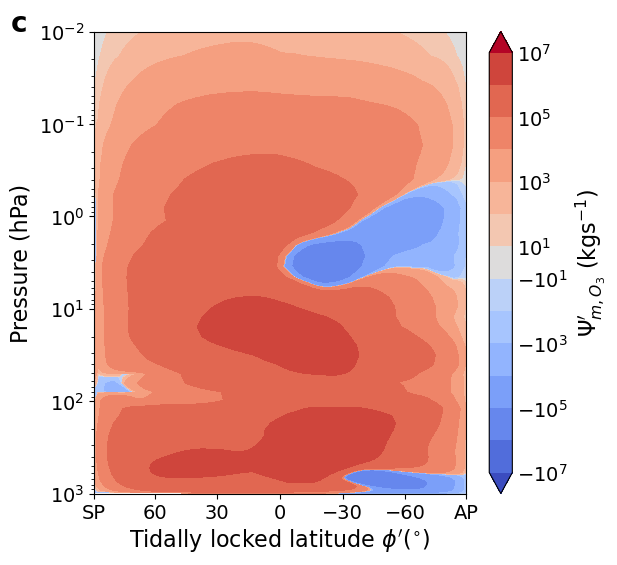

In [25]:

def meridional_o3mass_streamfunction(cubelist, lname='O3 MASS MIXING RATIO', time_slice=0, vmin=None, vmax=None,day_cube=False,night_cube=False, 
                                 lat_min=-90, lat_max=90, lon_min=0,lon_max=360, tl_coords=False, const=None, add_gyre=False,
                                     save=False, sublabel=False, sublabel_t='a', sublabel_t_y=1.0,
                                     name=None, model=aeolus.model.um):
    r"""
    Calculate the mean meridional mass streamfunction.

    * In height coordinates

    .. math::
        \Psi_M = - 2\pi cos\phi a \int_{z_{sfc}}^{z_{top}}\overline{\rho v} dz

    * In pressure coordinates

    .. math::
        \Psi_M = 2\pi cos\phi a \int_{0}^{p_{sfc}}\overline{\rho v} dp / g

    """
    for cube in cubelist:
        if cube.standard_name == 'eastward_wind':
            u = cube[:,:,:,:].copy()
            u=u.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.standard_name == 'northward_wind':
            v = cube[:,:,:,:].copy()
            v=v.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max))
        if cube.long_name == 'eastward_wind_div':
            u = cube[:,:,:,:].copy()
            u=u.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                u=u.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.long_name == 'northward_wind_div':
            v = cube[:,:,:,:].copy()
            v=v.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                v=v.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.standard_name =='air_pressure':
            pres_cube = cube[:,:,:,:].copy()
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                pres_cube=pres_cube.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                pres_cube=pres_cube.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.standard_name =='air_temperature':
            temp_cube = cube[:,:,:,:].copy()
            temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                temp_cube=temp_cube.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                temp_cube=temp_cube.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
        if cube.long_name == lname:
            o3mmr = cube[:,:,:,:].copy()
            o3mmr=o3mmr.collapsed('t', iris.analysis.MEAN)
            if day_cube==True:
                o3mmr=o3mmr.extract(iris.Constraint(longitude=lambda v: v > lon_max or v <= lon_min,
                                    latitude=lambda v: lat_min <= v <= lat_max))
            elif night_cube==True:
                o3mmr=o3mmr.extract(iris.Constraint(longitude=lambda v: lon_min < v <= lon_max,
                                    latitude=lambda v: lat_min <= v <= lat_max)) 
    v = v.regrid(u, iris.analysis.Linear())
    #print(o3mmr)
    height = [('level_height', v.coord('level_height').points)]
    pres_cube = pres_cube.interpolate(height, iris.analysis.Linear())
    temp_cube = temp_cube.interpolate(height, iris.analysis.Linear())
    o3mmr = o3mmr.interpolate(height, iris.analysis.Linear())
    rho =pres_cube / (const.molar_gas_constant * temp_cube)
    #print(pres_cube[19].data)
    lats = [('latitude', rho.coord('latitude').points)]
    v = v.interpolate(lats, iris.analysis.Linear())
        
    v = zonal_mean(v)
    rho = zonal_mean(rho)
    o3mmr = zonal_mean(o3mmr)
    rho.coord('level_height').bounds = None
    v.coord('level_height').bounds = None
        # Reverse the coordinate to start from the model top (where p=0 or z=z_top)
        # TODO: check if the coordinate is ascending or descending
    integrand = reverse(v * rho, 'level_height')
    res = -1 * cumsum(integrand, "z", axis_weights=True, model=model)
        # Reverse the result back
    res = reverse(res, model.z)

    # Calculate the constant: 2 pi cos\phi a
    streamf_const = 2 * np.pi * const.radius * lat_cos(res, model=model)
    res *= streamf_const*o3mmr
    pressure_zm = zonal_mean(pres_cube)
    res_p=interp_cube_from_height_to_pressure_levels(res, pressure_zm[:,:], pressure_zm[:,0].data)
    #levs=np.arange(-1.3e25, 1.43e25, 0.13e25)
    #lev_expcol = np.arange(-13,13,0.65)
    
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.225,sublabel_t_y, sublabel_t, size=20, weight='bold',transform=ax.transAxes)
    if tl_coords==True:
        ax.xaxis.set_major_locator(plt.MaxNLocator(7))
        #levs=[-1e3,-1e2,-1e1,-1e0,-1e-1,-1e-2,-1e-3,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3] ##NO2/HNO3
        levs=[-1e7,-1e6,-1e5,-1e4,-1e3,-1e2,-1e1,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
        cs = plt.contourf(res_p[:,:].coord('latitude').points, res_p[:,:].coord('air_pressure').points/100, 
                           -1*res_p[:,:].data, levels=levs, extend='both', cmap='coolwarm', norm=colors.SymLogNorm(
        linthresh=1e1, vmin=-1e8, vmax=1e8))
#        cs = iplt.contourf(-1*res_p[:,:], levels=35, cmap='PuOr_r', extend='both', locator=ticker.LogLocator(), norm=colors.TwoSlopeNorm(vmin=vmin,
#                                                                                                            vcenter=0, vmax=vmax))
        plt.xlabel('Tidally locked latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        plt.gca().invert_xaxis()
        labels = [w.get_text() for w in ax.get_xticklabels()]
        locs=list(ax.get_xticks())
        labels+=['SP']
        locs+=[89]
        labels+=['AP']
        locs+=[-89]        
        ax.set_xticklabels(labels)
        ax.set_xticks(locs)
        #ax.grid()
        plt.draw()
        plt.xlim(89,-89)
    else:
        levs=[-1e7,-1e6,-1e5,-1e4,-1e3,-1e2,1e-1,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
        cs = plt.contourf(res_p[:,:].coord('latitude').points, res_p[:,:].coord('air_pressure').points/100, 
                           res_p[:,:].data, levels=levs, extend='both', cmap='coolwarm',norm=colors.SymLogNorm(
        linthresh=1e1, vmin=-1e8, vmax=1e8))
        plt.xlabel('Latitude $\phi (^{\circ})$', fontsize=16)
    cbar = fig.colorbar(cs)
    cbar.locator = ticker.FixedLocator([-1e7, -1e5, -1e3, -1e1, 1e1, 1e3, 1e5,1e7])
    cbar.ax.set_yticklabels(['$-10^{7}$', '$-10^{5}$', '$-10^{3}$', '$-10^{1}$'
                             , '10$^{1}$', '10$^{3}$', '10$^{5}$','10$^{7}$']) 
    if tl_coords==True:    
        cbar.ax.set_ylabel('$\Psi^\prime_{m,O_3}$ (kgs$^{-1}$)', rotation=90, fontsize=16)
    else:
        cbar.ax.set_ylabel('$\Psi_{m,O_3}$  (kgs$^{-1}$)', rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=14)
    if day_cube==True:
        plt.title('For $\lambda^\prime$>%s$^{\circ}$ and ${\leq}$%s$^{\circ}$: Non-gyre' %(lon_max, lon_min), fontsize=16)
    if night_cube==True:
        plt.title('For %s$^{\circ}{<}\lambda^\prime{\leq}$%s$^{\circ}$: Non-gyre' %(lon_min, lon_max), fontsize=16)    #plt.gca().set_title(r'Latitude $1^\circ\mathrm{N}$', fontsize=20)
    if add_gyre==True:
        if day_cube==True:
            plt.title('For $\lambda^\prime$>%s$^{\circ}$ and ${\leq}$%s$^{\circ}$: Gyre' %(lon_max, lon_min), fontsize=16)
        if night_cube==True:
            plt.title('For %s$^{\circ}{<}\lambda^\prime{\leq}$%s$^{\circ}$: Gyre' %(lon_min, lon_max), fontsize=16) 
#         rect = patches.Rectangle((-75, 11000), 95, 89000, linewidth=1, edgecolor='black', facecolor='grey', alpha=0.5)
#         ax.add_patch(rect)
#         rx, ry = rect.get_xy()
#         cx = rx + rect.get_width()/2.0
#         cy = ry + rect.get_height()/2.0
        #ax.annotate("Gyre", (-27.5, 6e4), color='black', weight='bold', fontsize=16, ha='center', va='center')
        #plt.errorbar(-27.5, 98000,  xerr=47.5, capsize=12, elinewidth=4, markeredgewidth=4, color='black')
    plt.ylabel('Pressure (hPa)', fontsize=16)
    plt.yscale('log')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.gca().invert_yaxis()
    plt.ylim(1e3,1e-2)
    if save==True:
        plt.savefig('%s_%s_%s.pdf' %(name, lon_min, lon_max), bbox_inches = 'tight')
    plt.show()
#meridional_o3mass_streamfunction(pcb_tl, const=pcb_const, day_cube=False,night_cube=False,
#                                save=True, name='pcb_mmstream_o3', sublabel=True, sublabel_t='a')
meridional_o3mass_streamfunction(pcb_tl_regrid, tl_coords=True, lon_min=0, lon_max=360, const=pcb_const,
                                 save=True, sublabel=True, sublabel_t='c', name='pcb_tl_mmstream_o3')


# Figure 6a,b,c,d: ozone-weighted TL streamfunction for different ranges of tidally-locked longitude

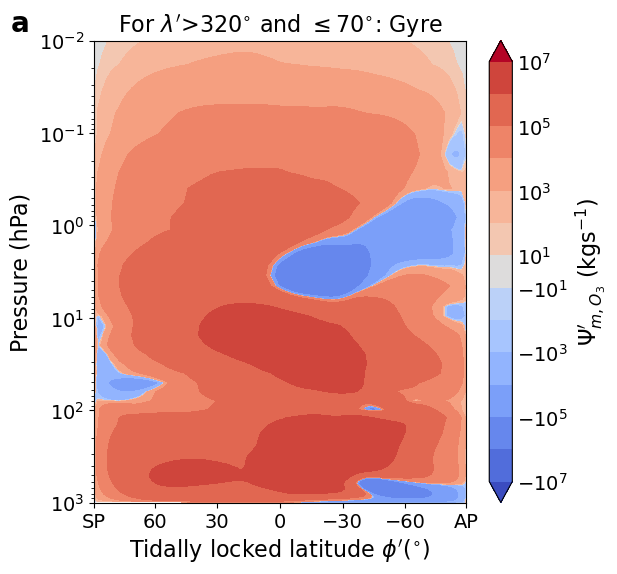

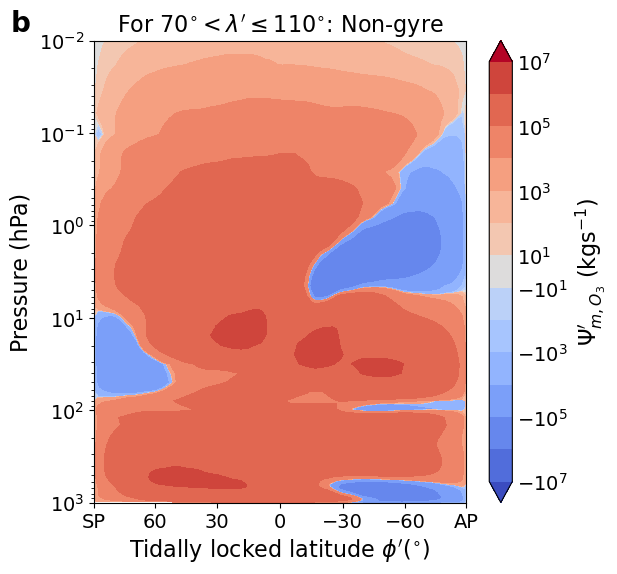

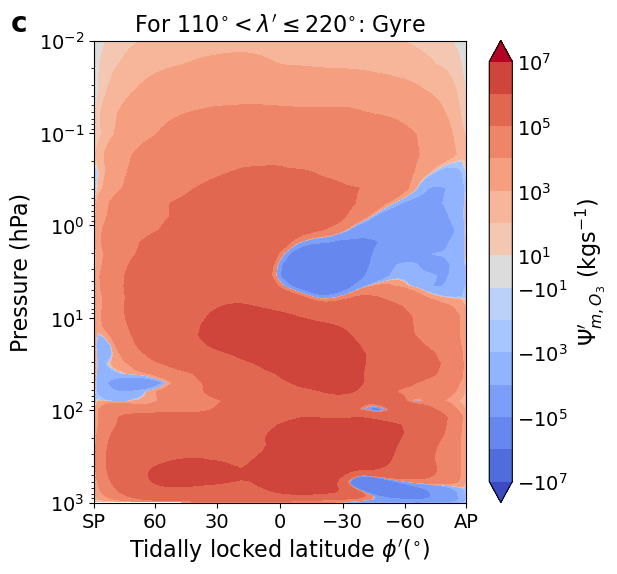

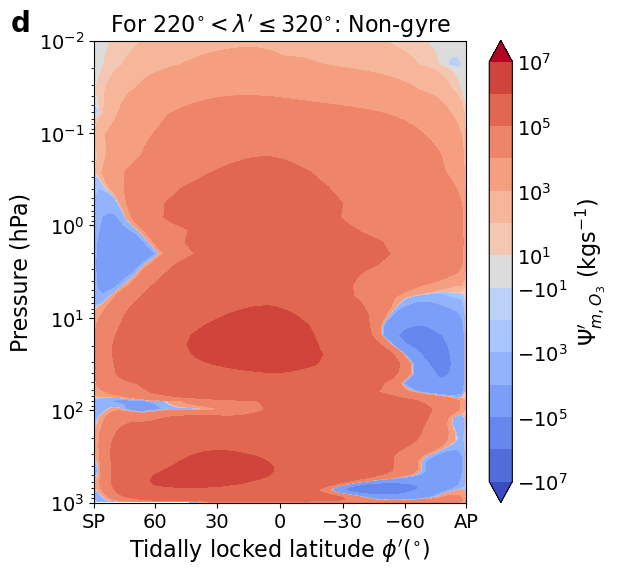

In [26]:
meridional_o3mass_streamfunction(pcb_tl_regrid, tl_coords=True, day_cube=True, night_cube=False,
                                 lon_min=70, lon_max=320, const=pcb_const, add_gyre=True,
                                 save=True, sublabel=True, sublabel_t='a', sublabel_t_y=1.02, name='pcb_tl_mmstream_o3')
meridional_o3mass_streamfunction(pcb_tl_regrid, tl_coords=True, day_cube=False, night_cube=True,
                                 lon_min=70, lon_max=110, const=pcb_const, 
                                 save=True, sublabel=True, sublabel_t='b', sublabel_t_y=1.02, name='pcb_tl_mmstream_o3')
meridional_o3mass_streamfunction(pcb_tl_regrid, tl_coords=True, day_cube=False, night_cube=True,
                                 lon_min=110, lon_max=220, const=pcb_const, add_gyre=True,
                                 save=True, sublabel=True, sublabel_t='c', sublabel_t_y=1.02, name='pcb_tl_mmstream_o3')
meridional_o3mass_streamfunction(pcb_tl_regrid, tl_coords=True, day_cube=False, night_cube=True,
                                 lon_min=220, lon_max=320, const=pcb_const,
                                 save=True, sublabel=True, sublabel_t='d', sublabel_t_y=1.02, name='pcb_tl_mmstream_o3')


# Figure 8: vertical flux of ozone (F$_{O3}$)

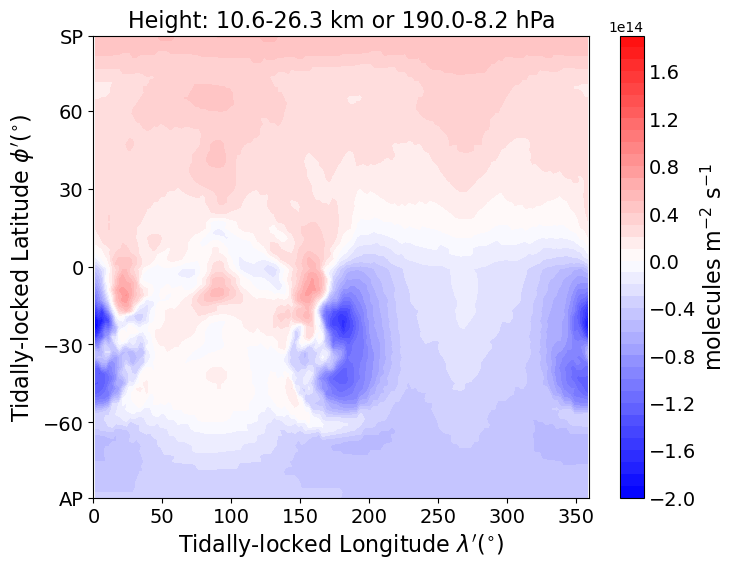

In [27]:
def plot_Fx(cubes, time_slice=-1, height_level_l=0, height_level=10, time_mean=False, save=False,tl_coord=False):            
    for cube in cubes:
        if cube.standard_name == 'eastward_wind':
            x_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                x_wind = cube[:time_slice,:,:,:].copy()
                x_wind=x_wind.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'air_temperature':
            temp_cube = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                temp_cube = cube[:time_slice,:,:,:].copy()
                temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'northward_wind':
            y_wind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                y_wind = cube[:time_slice,:,:,:].copy()
                y_wind=y_wind.collapsed('t', iris.analysis.MEAN)            
        if cube.standard_name =='upward_air_velocity':
            zwind = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                zwind = cube[:time_slice,:,:,:].copy()
                zwind=zwind.collapsed('t', iris.analysis.MEAN)    
        if cube.standard_name =='air_pressure':
            pressure = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                pressure = cube[:time_slice,:,:,:].copy()
                pressure=pressure.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='O3 MASS MIXING RATIO':
            o3mmr = cube[time_slice,:,:,:].copy()
            if time_mean == True:
                o3mmr = cube[:time_slice,:,:,:].copy()
                o3mmr=o3mmr.collapsed('t', iris.analysis.MEAN)
    height = [('level_height', o3mmr.coord('level_height').points)]
    pressure = pressure.interpolate(height, iris.analysis.Linear())
    zwind = zwind.interpolate(height, iris.analysis.Linear())
    # Regrid so that all three cubes are on the same x, y, z grid. Uses the x_wind as reference for the others
    p_heights = zonal_mean(meridional_mean(pressure))
    km_heights = np.round(pressure.coord('level_height').points*1e-03,1)
    o3mmr = vmr_molec(o3mmr, pressure, temp_cube)
    cube = zwind.copy()
    cube = cube*o3mmr
    #cube = ((o3mmr-zonal_mean(meridional_mean(o3mmr))))
    #cube *= zwind
    #cube = cube/(zonal_mean(meridional_mean(zwind*o3mmr)))
    full_cube_vcol=integrate(cube[height_level_l:height_level,:,:], 'level_height')
    #levs=np.arange(-60,65,5)
    #norm = colors.TwoSlopeNorm(vmin=cube[height_level,:,:].data.min(), vmax = cube[height_level,:,:].data.max(), vcenter=0)
    levs=[-1e6,-1e5,-1e4,-1e3,-1e2,1e2,1e3,1e4,1e5,1e6]
    norm=colors.TwoSlopeNorm(vmin=-4e14, vmax=4e14, vcenter=0)
    levs=np.arange(-2e14,2e14, 1e13)
    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    plt.title('Height: %s-%s km or %s-%s hPa' %(km_heights[height_level_l],km_heights[height_level], 
             (np.round(p_heights[height_level_l].data/100,1)),(np.round(p_heights[height_level].data/100,1))), fontsize=16)
    c=plt.contourf(full_cube_vcol[:,:].coord('longitude').points,full_cube_vcol[:,:].coord('latitude').points,
                   full_cube_vcol[:,:].data, levels=25, extend='neither', cmap='seismic', norm=norm)
    c=plt.contourf(full_cube_vcol[:,:].coord('longitude').points,full_cube_vcol[:,:].coord('latitude').points,
                   full_cube_vcol[:,:].data, levels=levs, extend='neither', cmap='seismic', norm=norm)
    cbar = fig.colorbar(c)
    #cbar.locator = ticker.FixedLocator([-1e6, -1e4, -1e2, 1e2, 1e4,1e6])
    #cbar.ax.set_yticklabels(['$-10^{6}$', '$-10^{4}$', '$-10^{2}$', '10$^{2}$', '10$^{4}$','10$^{6}$']) 
    cbar.ax.set_ylabel('molecules m$^{-2}$ s$^{-1}$', rotation=90, fontsize=16)
    cbar.ax.tick_params(length=0, labelsize=14) 
    if tl_coord==True:
        ax.yaxis.set_major_locator(plt.MaxNLocator(7))
        plt.ylabel('Tidally-locked Latitude $\phi^{\prime} (^{\circ})$', fontsize=16)
        plt.xlabel('Tidally-locked Longitude $\lambda^{\prime} (^{\circ})$', fontsize=16)
        #         plt.axvline(70, color='grey')#65
#         plt.axvline(110, color='grey')#115
#         plt.axvline(230, color='grey')#220
#         plt.axvline(305, color='grey')#312
        #plt.title('T$_{surf}$, tidally-locked coordinates', fontsize=16)
        plt.draw() # this is required, or the ticklabels may not exist (yet) at the next step
        labels = [w.get_text() for w in ax.get_yticklabels()]
        locs=list(ax.get_yticks())
        labels+=['SP']
        locs+=[89]
        labels+=['AP']
        locs+=[-89]        
        ax.set_yticklabels(labels)
        ax.set_yticks(locs)
        #ax.grid()
        plt.draw()
        plt.ylim(-89,89)
    else:
        plt.ylabel('Latitude $\phi (^{\circ})$', fontsize=16)
    #    plt.xlabel('Longitude $\lambda (^{\circ})$', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,360)
    plt.ylim(-89,89)
    if save==True:
        plt.savefig('vert_o3flux_%s.pdf' %(time_slice), bbox_inches = 'tight', pad_inches=0)
plot_Fx(pcb_tl_regrid, time_slice=99, 
        height_level_l=22, height_level=36, time_mean=True, tl_coord=True, save=True)

# Figure 10: Radiative heating rates and partition into components

### Import different cubes to calculate individual contributions

In [29]:
pcb_tl_hrates_nono3= iris.load('data/pcb_hrates_nono3.nc')
newheight(pcb_tl_hrates_nono3)
pcb_tl_hrates_noco2 = iris.load('data/pcb_hrates_noco2.nc')
newheight(pcb_tl_hrates_noco2)
pcb_tl_hrates_noh2o = iris.load('data/pcb_hrates_noh2o.nc')
newheight(pcb_tl_hrates_noh2o)
pcb_tl = iris.load('data/pcb_tl_o3circ_8340_900.nc')
newheight(pcb_tl)

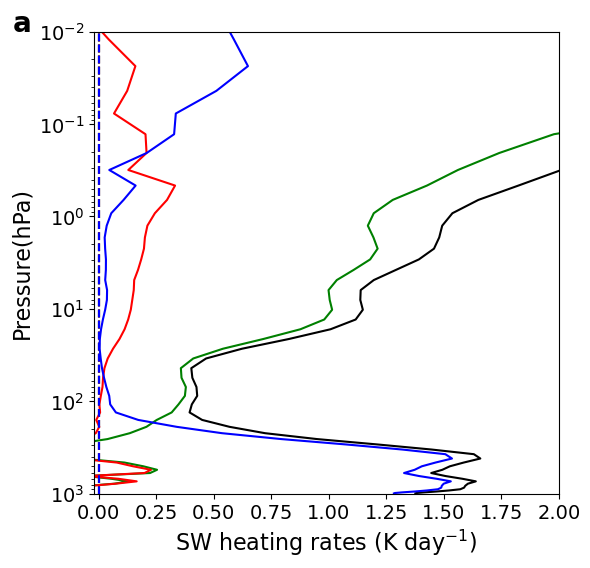

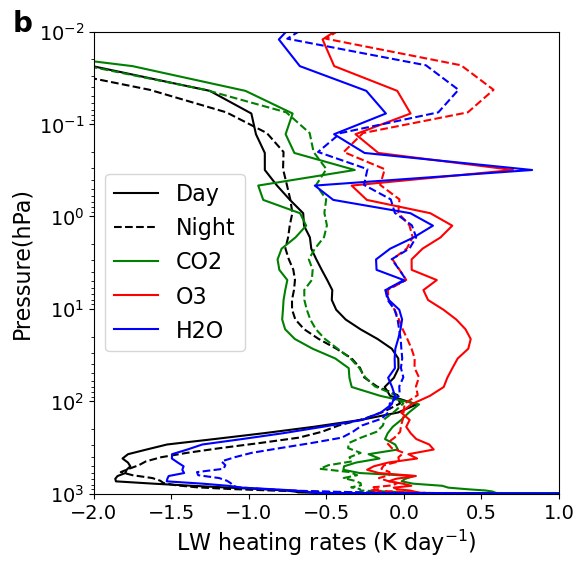

In [31]:
def rf_z(cubestl, cubestl2,cubestlco2,cubestlh2o,lname='air_temperature', xlab_in='Air temperature (K)', 
         legend=True, x_log=False, xlim_low=None, xlim_upp=None, time_slice=0, level=0, 
         sublabel=False, sublabel_t='a', save=False, name=None):
    for cube in cubestl:
        if cube.standard_name == lname:
            t_air = cube.copy()
            t_air = t_air.collapsed('t', iris.analysis.MEAN)
        if cube.long_name == lname:
            t_air = cube.copy()
            t_air = t_air.collapsed('t', iris.analysis.MEAN)        
        if cube.standard_name =='air_pressure':
            pres_cube = cube[:,:,:,:].copy()
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
    for cubeo3 in cubestl2:
        if cubeo3.standard_name == lname:
            t_airo3 = cubeo3.copy()
            t_airo3 = t_airo3.collapsed('t', iris.analysis.MEAN)
        if cubeo3.long_name == lname:
            t_airo3 = cubeo3.copy()
            t_airo3 = t_airo3.collapsed('t', iris.analysis.MEAN)        
        if cubeo3.standard_name =='air_pressure':
            pres_cubeo3 = cubeo3[:,:,:,:].copy()
            pres_cubeo3=pres_cubeo3.collapsed('t', iris.analysis.MEAN)
    for cubeco2 in cubestlco2:
        if cubeco2.standard_name == lname:
            t_airco2 = cubeco2.copy()
            t_airco2 = t_airco2.collapsed('t', iris.analysis.MEAN)
        if cubeco2.long_name == lname:
            t_airco2 = cubeco2.copy()
            t_airco2 = t_airco2.collapsed('t', iris.analysis.MEAN)        
        if cubeco2.standard_name =='air_pressure':
            pres_cubeco2 = cubeco2[:,:,:,:].copy()
            pres_cubeco2=pres_cubeco2.collapsed('t', iris.analysis.MEAN) 
    for cubeh2o in cubestlh2o:
        if cubeh2o.standard_name == lname:
            t_airh2o = cubeh2o.copy()
            t_airh2o = t_airh2o.collapsed('t', iris.analysis.MEAN)
        if cubeh2o.long_name == lname:
            t_airh2o = cubeh2o.copy()
            t_airh2o = t_airh2o.collapsed('t', iris.analysis.MEAN)        
        if cubeh2o.standard_name =='air_pressure':
            pres_cubeh2o = cubeh2o[:,:,:,:].copy()
            pres_cubeh2o=pres_cubeh2o.collapsed('t', iris.analysis.MEAN) 

    co2_sw=t_air-t_airco2
    o3_sw=t_air-t_airo3
    h2o_sw=t_air-t_airh2o
    
    height = [('level_height', t_air.coord('level_height').points)]
    pres_cube = pres_cube.interpolate(height, iris.analysis.Linear())
    t_air_p=interp_cube_from_height_to_pressure_levels(t_air, pres_cube[:,:,:], pres_cube[:,:].data)
    tair_day, tair_night = hemisphere_sep(t_air_p)
    
#     height2 = [('level_height', t_air2.coord('level_height').points)]
#     pres_cube2 = pres_cube2.interpolate(height2, iris.analysis.Linear())
    co2_sw_p=interp_cube_from_height_to_pressure_levels(co2_sw, pres_cube[:,:,:], pres_cube[:,:].data)
    co2_sw_day, co2_sw_night = hemisphere_sep(co2_sw_p)
    o3_sw_p=interp_cube_from_height_to_pressure_levels(o3_sw, pres_cube[:,:,:], pres_cube[:,:].data)
    o3_sw_day, o3_sw_night = hemisphere_sep(o3_sw_p)
    h2o_sw_p=interp_cube_from_height_to_pressure_levels(h2o_sw, pres_cube[:,:,:], pres_cube[:,:].data)
    h2o_sw_day, h2o_sw_night = hemisphere_sep(h2o_sw_p)
    
    fig=plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if sublabel==True:
        ax.text(-0.175,1.0, sublabel_t, size=20, weight='bold',transform=ax.transAxes)
    iplt.plot(tair_day[:]*24*3600, tair_day[:].coord("air_pressure")/100, color='black', label='Day')
    iplt.plot(tair_night[:]*24*3600, tair_night[:].coord("air_pressure")/100, color='black', ls='--', label='Night')
    iplt.plot(co2_sw_day[:]*24*3600, co2_sw_day[:].coord("air_pressure")/100, color='green', label='CO2')
    iplt.plot(co2_sw_night[:]*24*3600, co2_sw_night[:].coord("air_pressure")/100, color='green', ls='--')#, label='CO2')
    iplt.plot(o3_sw_day[:]*24*3600, o3_sw_day[:].coord("air_pressure")/100, color='red', label='O3')
    iplt.plot(o3_sw_night[:]*24*3600, o3_sw_night[:].coord("air_pressure")/100, color='red', ls='--')#, label='O3')
    iplt.plot(h2o_sw_day[:]*24*3600, h2o_sw_day[:].coord("air_pressure")/100, color='blue', label='H2O')
    iplt.plot(h2o_sw_night[:]*24*3600, h2o_sw_night[:].coord("air_pressure")/100, color='blue', ls='--')#, label='H2O')
    #plt.gca().set_title('0$^\circ$ hemi', fontsize=18)
    plt.xlabel(xlab_in, fontsize=16)
    plt.ylabel('Pressure(hPa)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if legend==True:
        plt.legend(loc='best', fontsize=16)
    plt.yscale('log')
    plt.grid(None)
    plt.gca().invert_yaxis()
    plt.xlim(xlim_low,xlim_upp)
    if x_log==True:
        plt.xscale('log')
    plt.ylim(1e3,1e-2)
    plt.grid()
    if save==True:
        plt.savefig('heatrates_%s.pdf' %(name), bbox_inches = 'tight')
    plt.show()
    
rf_z(pcb_tl, pcb_tl_hrates_nono3, pcb_tl_hrates_noco2, pcb_tl_hrates_noh2o, lname='CLEAR-SKY SW HEATING RATES', xlab_in='SW heating rates (K day$^{-1}$)',
    legend=False, x_log=False, xlim_low=-0.020, xlim_upp=2e0, sublabel=True, sublabel_t='a', save=True, name='sw')
rf_z(pcb_tl, pcb_tl_hrates_nono3, pcb_tl_hrates_noco2, pcb_tl_hrates_noh2o, lname='CLEAR-SKY LW HEATING RATES', xlab_in='LW heating rates (K day$^{-1}$)',
    x_log=False, xlim_low=-2e0, xlim_upp=1e0, sublabel=True, sublabel_t='b', save=True, name='lw')